In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Set up files
mydir = '/Users/helenhu/Documents/MATLAB/Correlation/ordinaryFiveBlocksData'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]

numSubj = len(files)
print('Number of subjects: ', numSubj)

Number of subjects:  12


In [3]:
# Initialize variables
numRepeats = 10 # 10 passages
block_start = 2
block_end = block_start + numRepeats - 1   # the last block
numQPerPsg = 5

subj_include = [None] * numSubj
subj_readingSpeed = [None] * numSubj
subj_thresholds = np.full((numSubj, numRepeats), np.nan)

print('Shape thresholds matrix:', subj_thresholds.shape)

Shape thresholds matrix: (12, 10)


In [5]:
for subj in range(numSubj):
    mainOutput = pd.read_csv(os.path.join(mydir, files[subj]))

    psg_resp = np.full((numRepeats, numQPerPsg), np.nan)

    # Check if the participant got at least 50% accuracy
    for psg in range(2, 12):
        questionBlock = psg * 2

        labelName_question = f"{questionBlock}_1"
        questionBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_question].iloc[:numQPerPsg]

        psg_resp[psg - 2, :] = (
            questionBlock_cond['questionAndAnswerCorrectAnswer'] ==
            questionBlock_cond['questionAndAnswerResponse']
        ).values

    psg_percentCorrect = np.nanmean(psg_resp, axis=1)
    assert psg_percentCorrect.shape == (numRepeats,)

    # Whether we should include this passage
    psg_include = np.where(psg_percentCorrect >= 0.6)[0]


    # Calculate reading speed
    psg_wordsPerMin = np.full(numRepeats, np.nan)
    for psg in range(2, 12):
        readingBlock = psg * 2 - 1

        labelName_reading = f"{readingBlock}_1"
        readingBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_reading].iloc[1:3]
        numWords = readingBlock_cond['readingPageWords']
        reading_time = readingBlock_cond['readingPageDurationOnsetToOffsetSec']
        pg_wordsPerMin = numWords / (reading_time / 60)
        psg_wordsPerMin[psg - 2] = np.nanmean(pg_wordsPerMin)

    subj_include[subj] = psg_include
    psg_wordsPerMin[np.where(psg_percentCorrect < 0.6)] = np.nan
    subj_readingSpeed[subj] = psg_wordsPerMin[psg_include]
    subj_thresholds[subj, psg_include] = psg_wordsPerMin[psg_include]


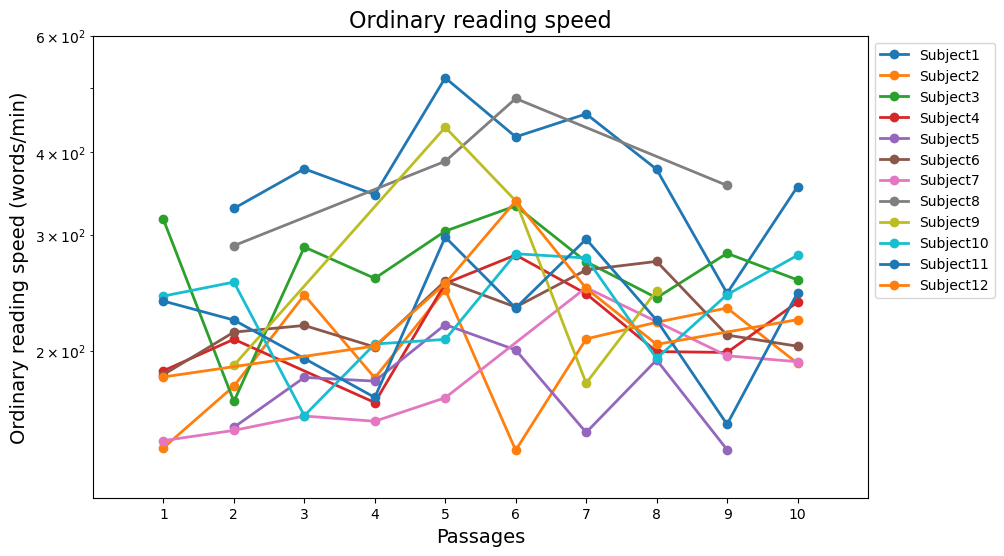

In [16]:
# Plot reading speed
# passage 0 was excluded as practice
cmap = plt.cm.jet(np.linspace(0, 0.8, numSubj))

plt.figure(figsize = (10, 6))
for subj in range(numSubj):
    plt.plot(subj_include[subj]+1, subj_readingSpeed[subj], 'o-', linewidth=2, #color=cmap[subj],
        label=f'Subject{subj + 1}'
    )
plt.xlim([0, 11])
plt.xticks(range(1, 11))
plt.ylim([120, 600])
plt.title('Ordinary reading speed', fontsize = 16)
plt.xlabel('Passages', fontsize = 14)
plt.ylabel('Ordinary reading speed (words/min)', fontsize = 14)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
